## This version uses the correct matrices in the linear equation. It however seems to give nearly indentical results to my previous version.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

In [2]:
def gaussian(x, m=0., s=1.0):
    out = 1/(s*np.sqrt(2*np.pi))*np.exp(-(x-m)**2./(2.*s**2.))
    return out / out.sum() / (x[1] - x[0])

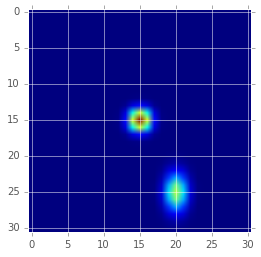

In [57]:
from scipy.stats import multivariate_normal

## see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html

def gaussian2d(grid, m=None, s=None):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    var = multivariate_normal(mean=m, cov=cov)
    return var.pdf(grid)

x, y = np.mgrid[-15:16:1, -15:16:1]
grid = np.dstack((x, y))
g1 = gaussian2d(grid) + gaussian2d(grid, [10,5], [3,1])
plt.imshow(g1)

## Update: it looks like the actual code uses chebyshev1 polynomials!

Note these are essentially the same but with different scale factors.

In [25]:
from numpy.polynomial.chebyshev import chebval
def chebval2d(x, y, xord, yord):
    cx = chebval(x, xord)
    cy = chebval(y, yord)
    h0 = np.outer(cx, cy)
    return h0

(31, 31)


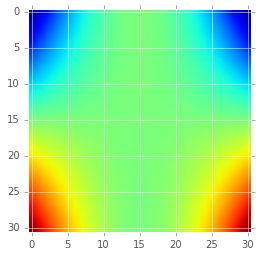

In [56]:
## TBD: use chebgrid2d:
## http://students.mimuw.edu.pl/~pbechler/numpy_doc/reference/generated/numpy.polynomial.chebyshev.chebgrid2d.html

x = np.arange(-15, 16, 1)
y = x.copy()

#h0 = chebval2d(x, y, [1, 0, 0], [0, 1, 0])
h0 = chebval2d(x, y, [0, 1, 0], [0, 1, 0])
h0 = chebval2d(x, y, [1, 0, 0], [0, 1, 0])
h0 = chebval2d(x, y, [0, 1, 0], [0, 0, 1])
print h0.shape
plt.imshow(h0)

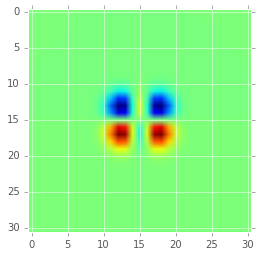

In [59]:
gh0 = gaussian2d(grid, s=[3., 3.]) * h0
#gh1 = gaussian(x) * h1
#gh2 = gaussian(x) * h2
plt.imshow(gh0)
#plt.plot(x, gh1)
#plt.plot(x, gh2)

## Generate AL basis funcs now...

use same parameters as from the stack.

In [6]:
# Parameters from stack
sigGauss = [0.75, 1.5, 3.0]
degGauss = [4, 2, 2]
betaGauss = 2   # in the Becker et al. paper sigGauss is 1 but PSF is more like 2 pixels?
# Parameters from and Becker et al. (2012)
#sigGauss = [0.75, 1.5, 3.0]
#degGauss = [6, 4, 2]

def chebGauss(x, m=0., s=1., ord=0, beta=1.):
    ga = gaussian(x, m, s/beta)
    coef = np.zeros(ord+1)
    coef[-1] = 1
    print s, ord, coef
    ch = chebval(x, coef)
    return ga * ch

0.75 0 [ 1.]
0.75 1 [ 0.  1.]
0.75 2 [ 0.  0.  1.]
0.75 3 [ 0.  0.  0.  1.]
1.5 0 [ 1.]
1.5 1 [ 0.  1.]
3.0 0 [ 1.]
3.0 1 [ 0.  1.]
(120, 8)


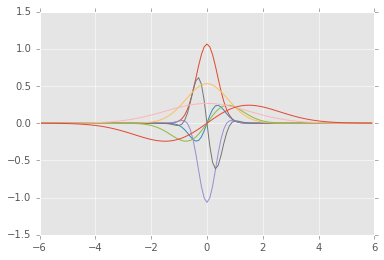

In [7]:
basis = [chebGauss(x, m=0, s=sig, ord=deg, beta=betaGauss) for i,sig in enumerate(sigGauss) for deg in range(degGauss[i])]
basis = np.vstack(basis).T  # put the bases into columns
print basis.shape
# basis = pd.DataFrame(basis); basis.plot()
for b in basis.T:
    plt.plot(x, b)

Make the two "images". `im1` is the template, `im2` is the science image.

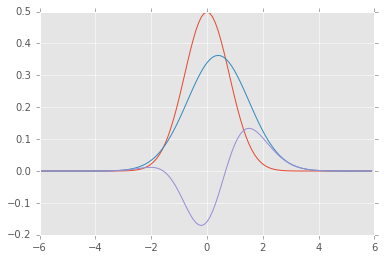

In [8]:
im1 = gaussian(x, m=0.0, s=0.8)  # template
im2 = gaussian(x, m=0.4, s=1.1)  # science image; include a slight registration error
plt.plot(x, im1); plt.plot(x, im2); plt.plot(x, im2-im1)

Convolve im2 with the basis functions, and make these the *new* bases.

(120,) (120,) (120,) (120,)


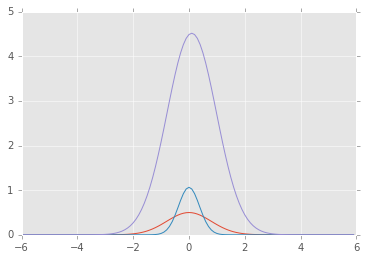

In [9]:
# Test convolve template with the first basis
tmp = np.convolve(im1, basis[:,0], mode='same')
print im2.shape, basis[:,0].shape, tmp.shape, x.shape
plt.plot(x, im1)
plt.plot(x, basis[:,0])
plt.plot(x, tmp)

In [10]:
basis2 = [np.convolve(im1, b, mode='same') - im1 for b in basis.T]
basis2 = np.vstack(basis2).T
print basis2.shape

(120, 8)


Do the linear fit to compute the matching kernel. The resulting fit is the convolved diffim.

Here we are plotting the resulting fitted diffim (red) vs. the actual diffim (blue)

[-0.06511401 -0.0362048  -0.05463125 -0.01312505  0.1257876   0.05720871
  0.00165638  0.00016149]
(120, 8) (120,)


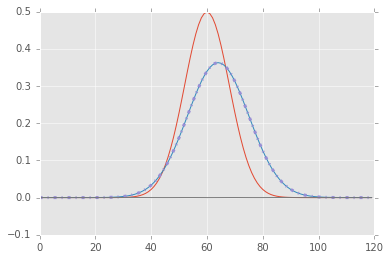

In [11]:
pars = np.linalg.lstsq(basis2, im2)[0]
print pars
fit = (pars * basis2).sum(1)
print basis2.shape, fit.shape
#plt.plot(x, im2 - fit)  # science - convolved template (red)
#plt.plot(x, im2 - im1)  # science - original template (blue)
plt.plot(im1)  # original template (red)
plt.plot(fit)  # convolved template (blue)  -- note looks purple because it's right on top of im2
plt.plot(im2, ls='-.', lw=3)  # science image (dotted, purple)
plt.plot(im2 - fit)  # diffim (grey)

Look at the resulting matching kernel by multiplying the fitted parameters times the original basis funcs. and test that actually convolving it with the template gives us a good subtraction.

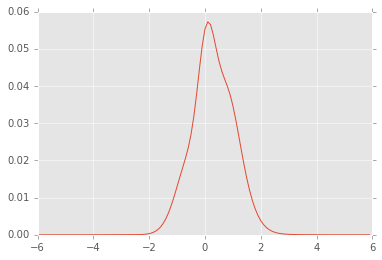

In [12]:
fit = (pars * basis).sum(1)
fit /= fit.sum()
plt.plot(x, fit)  # this plots the matching kernel

Compare the convolved template to the science image. Also plot the new diffim for comparison.

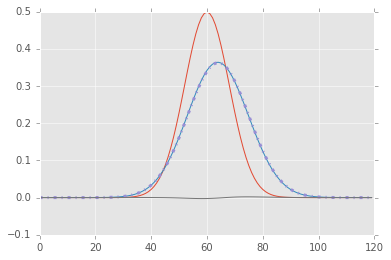

In [13]:
conv_im1 = np.convolve(im1, fit, mode='same')
plt.plot(im1)  # original template (red)
plt.plot(conv_im1)  # convolved template (blue)
plt.plot(im2, ls='-.', lw=3)  # science image (dotted, purple)
plt.plot(im2 - conv_im1)  # diffim (grey)

Create the $b_i$ and $M_{ij}$ from the A&L (1998) and Becker (2012) papers. This was done wrong in the previous version of notebook 3 (and above), although it gives identical results.

(8,)
(8, 8)
[-0.06511401 -0.0362048  -0.05463125 -0.01312505  0.1257876   0.05720871
  0.00165638  0.00016149]
(120, 8) (120,)
[  2.28073116e-12  -3.50362794e-12   2.35032827e-12  -1.79336233e-12
  -7.98638933e-13   3.76532139e-13   1.11417819e-13  -2.11219930e-14]


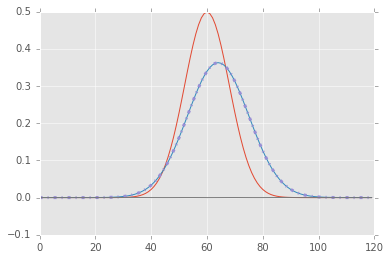

In [14]:
b = (basis2.T * im2).sum(1)
print b.shape

M = np.dot(basis2.T, basis2)
print M.shape

pars2 = np.linalg.lstsq(M, b)[0]
print pars2
fit2 = (pars2 * basis2).sum(1)
print basis2.shape, fit2.shape
#plt.plot(x, im2 - fit)  # science - convolved template (red)
#plt.plot(x, im2 - im1)  # science - original template (blue)
plt.plot(im1)  # original template (red)
plt.plot(fit2)  # convolved template (blue)  -- note looks purple because it's right on top of im2
plt.plot(im2, ls='-.', lw=3)  # science image (dotted, purple)
plt.plot(im2 - fit2)  # diffim (grey)

print pars2-pars

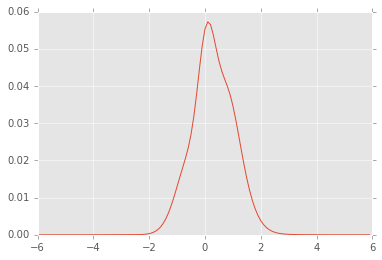

In [15]:
fit2 = (pars2 * basis).sum(1)
fit2 /= fit2.sum()
plt.plot(x, fit2)  # this plots the matching kernel

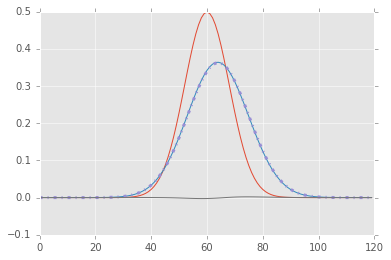

In [16]:
conv_im1a = np.convolve(im1, fit2, mode='same')
plt.plot(im1)  # original template (red)
plt.plot(conv_im1a)  # convolved template (blue)
plt.plot(im2, ls='-.', lw=3)  # science image (dotted, purple)
plt.plot(im2 - conv_im1a)  # diffim (grey)

Add taking into account PSF variations... (next notebook, #4)